# Gradient Descent

The central idea of Gradient Descent is the foundation for training a wide variety of models. Whatever your model, if you list the trainable parameters in a single vector, imagine plotting each possible setting of the parameters against the **loss** -- some function that scores the deviation between the predictions (using those parameters) and the actual labels. An example loss contour plot, with just 2 parameters is on the right -- the loss is on the y-axis. The goal in machine learning is to find the parameter settings that minimize the loss.

<img style="float: right;" src="Resources/loss_contours.jpg">

But we don't want to enumerate all possible parameter settings and compute the loss for each one. Instead, we start with some arbitrary initial setting, compute the loss, and make an update to the parameters. Gradient descent specifies that update. It says that we estimate the **gradient** -- the slope of the loss contour, and take a step along the steepest descent. Of course this is only possible if the loss function is differentiable. In each iteration, we compute the loss, estimate the gradient, and make an update to the parameters, until a minimum is reached.

Note that gradient descent is a greedy algorithm. It can't see that there may be many local minima, so depending on the starting point, it may or may not find the global minimum. While the landscape is easy for us to see in 2 dimensions, we typically use gradient descent in much higher dimensional space where the landscape is far too complex to tell where the minima are.

### Linear Regression

In this notebook, we'll demonstrate gradient descent for linear regression. That is, we'll try to estimate parameters $\theta$ to approximate $y$ as a linear function $h_\theta(x)$ (this notation means that $h$ is a function of $x$, parameterized by $\theta$). $x = \{x_0, x_1, ..., x_n\}$ are the features, and we'll assume that $x_0=1$, an intercept (or bias) term. We can write $h$ as a sum or using matrix notation:

\begin{align*}
h_\theta(x) = \sum_{i=0}^n \theta_i x_i = \theta^T x
\end{align*}

Note that this is also called an **affine transform** (see the [Tensorflow Primer](https://www.tensorflow.org/tutorials)). In linear regression, the loss, $J(\theta)$, is the squared difference between predictions $h_\theta(x)$ and $y$. In the following equation, we sum the loss over each of the $m$ training examples and divide by 2 because when we take the gradient (below), it will cancel the squared term:

\begin{align*}
J(\theta) = \frac{1}{2m} \sum_{i=0}^m (h_\theta(x^{(i)}) - y^{(i)})^2
\end{align*}

Finally, we can derive the parameter update rule by computing the gradient of the loss function. We need a gradient for each feature in $x$, so we'll show how to compute the gradient with respect to $\theta_j$. Let's remove the sum over examples for simplicity and just take the derivative for a single training example:

\begin{align}
\frac{\partial}{\partial \theta_j} J(\theta) &= \frac{\partial}{\partial \theta_j} \frac{1}{2} (h_\theta(x) - y)^2 \\
&= 2 \cdot \frac{1}{2} (h_\theta(x) - y) \cdot \frac{\partial}{\partial \theta_j} (h_\theta(x) - y) \\
&= (h_\theta(x) - y) \frac{\partial}{\partial \theta_j} (\sum_{i=0}^n \theta_i x_i - y) \\
&= (h_\theta(x) - y)x_j
\end{align}

The derivation has 2 key steps:
1. Apply the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) (step 1 -> 2).
2. The derivative with respect to $\theta_j$ of $h_\theta(x)$ is only non-zero for $\theta_j x_j$. For this component, the derivative is $x_j$ since the feature value is treated as a constant (step 3 -> 4).

Ok, that's it. We can now implement gradient descent for linear regression. Note that unlike in the loss contour above, the loss for linear regression is **convex**, meaning that there are no local minima that are not the global minimum. As a result, taking steps in the direction of the gradient will eventually land us at the global minimum.

In [1]:
# Run this cell to import everything we'll need.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import inv
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)
sns.set(style="darkgrid", context="talk")

### Boston housing data

We'll use the [Boston housing dataset](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), a classic from the 1970s (so the prices are pretty outdated). Each example data point represents a neighborhood in the Boston area. The target is the median home value in that area and there are 13 features are other potentially correlated characteristics including:

* (1) CRIM - per capita crime rate by town
* (2) ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* (3) INDUS - proportion of non-retail business acres per town.
* (4) CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

We'll treat this is a regression problem -- predict the target value from the features. Certainly this is not a language processing example, but it allows us focus on gradient descent rather than issues like feature sparsity.

Training data shape: (350, 13)
Test data shape: (156, 13)


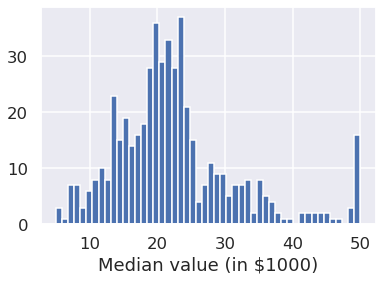

In [3]:
# Load the Boston housing data and show a histogram of the target (house value).
boston = load_boston()
plt.hist(boston.target, 50)
plt.xlabel('Median value (in $1000)')

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
X, Y = boston.data, boston.target
np.random.seed(0)
shuf_idx = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuf_idx], Y[shuf_idx]

# Split into train and test.
train_data, train_labels = X[:350], Y[:350]
test_data, test_labels = X[350:], Y[350:]
print('Training data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

### Gradient Descent algorithm

Let's turn the math above into code. We'll initialize our parameters, then in each epoch (pass over the training data), we'll compute predictions -- $h_\theta(x)$, which in turn are used to compute the loss, then make a parameter update based on the gradient of the loss. Importantly, we scale the update by a **learning rate**, thus making our updates more conservative.

In [6]:
def gradient_descent(data, labels, learning_rate, num_epochs):
    # Add a 1 to each feature vector so we learn an intercept (or bias).
    X = np.c_[np.ones(data.shape[0]), data]
    
    # m = number of samples, n = number of features
    m, n = X.shape
    
    # We'll use a vector of size n to store the learned parameters.
    theta = np.ones(n)
    
    # Keep track of the training loss after each step.
    losses = []
    
    for epoch in range(num_epochs):
        # Get the current predictions for the training examples given the current estimate of theta.
        hypothesis = np.dot(X, theta)
        
        # Get the difference between the predictions and the actual target values.
        diff = hypothesis - labels
        
        # In standard linear regression, we want to minimize the sum of squared differences.
        loss = np.sum(diff ** 2) / (2 * m)
        losses.append(loss)
        
        # Compute the gradient with respect to the loss.
        gradient = np.dot(X.T, diff) / m

        # Update theta, scaling the gradient by the learning rate.
        theta = theta - learning_rate * gradient
        
    # Plot the loss during training.
    plt.plot(losses)
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.show()
        
    return theta

### Running gradient descent

Let's run gradient descent using just the first feature (crime rate) in addition to the bias term. After 500 iterations, the loss looks like it has (nearly) converged.

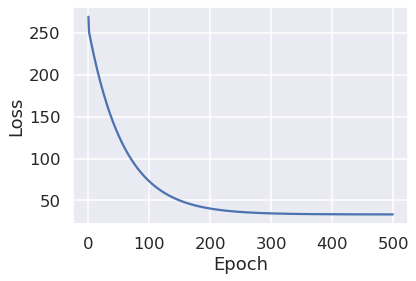

In [7]:
# Run gradient descent with 1 feature for 500 iterations and learning rate .01.
theta = gradient_descent(train_data[:,0:1], train_labels, .01, 500)

### Compare with OLS and SKlearn

Let's compare our results to sklearn's regression as well as the algebraic solution to [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares). Try increasing the number of iterations above to see whether we get closer.

By the way, do the learned coefficients look reasonable? The median home price appears to decrease (the coefficient is negative) as the crime rate increases.

In [9]:
def OLS(X, Y):
    # Add the intercept.
    X = np.c_[np.ones(X.shape[0]), X]
    
    # We use np.linalg.inv() to compute a matrix inverse.
    return np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y))

ols_solution = OLS(train_data[:,0:1], train_labels)

lr = LinearRegression(fit_intercept=True)
lr.fit(train_data[:,0:1], train_labels)

print('Our estimated theta:     %.4f + %.4f*CRIM' %(theta[0], theta[1]))
print('OLS estimated theta:     %.4f + %.4f*CRIM' %(ols_solution[0], ols_solution[1]))
print('sklearn estimated theta: %.4f + %.4f*CRIM' %(lr.intercept_, lr.coef_[0]))

Our estimated theta:     23.3582 + -0.3493*CRIM
OLS estimated theta:     23.6593 + -0.3604*CRIM
sklearn estimated theta: 23.6593 + -0.3604*CRIM


### Using more features

Let's try training using 5 features. Now, our gradient descent code will be computing the loss based on predictions using 5 parameters, then estimating a gradient for each feature.

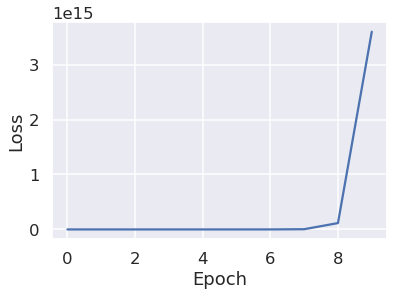

In [10]:
theta = gradient_descent(train_data[:,0:5], train_labels, .01, 10)

### Choosing a learning rate

<img style="float: right;" src="Resources/learning_rate.jpg">

It looks like the loss is exploding! This can happen when the learning rate is too high because the updated parameters skip over the minimum and the loss ends up larger than it was before. On the other hand, if the learning rate is too small, it could take too long to converge. In practice, choosing the right learning rate is often a matter of trial and error. Often, we decrease the learning rate over time according to a schedule, reflecting the intuition that we make smaller and smaller updates as we get closer to the minimum.

Let's reduce the learning rate by a factor of 10 and try again.

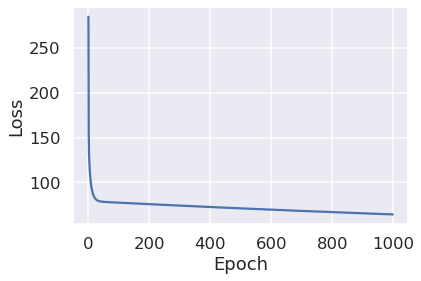

In [11]:
theta = gradient_descent(train_data[:,0:5], train_labels, .001, 1000)

### Feature scaling

The loss is decreasing, but it's taking a long time to converge. Gradient descent is much more efficient when the scale of the features is similar. Roughly speaking, this is because we compute the gradient with respect to each feature, but are applying the same learning rate. The plots below show how varied the scales are (see the x-axes). Note that the [Adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad) algorithm, for exampe, can adjust the learning rate for each feature.

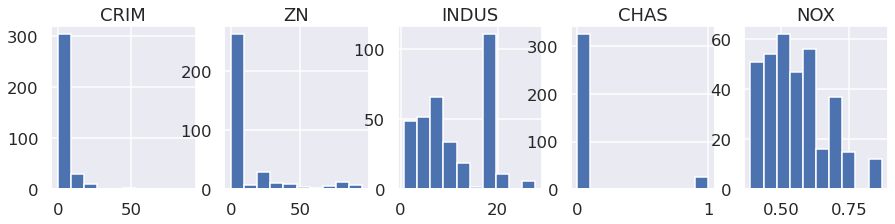

In [13]:
plt.figure(figsize=(15, 3))
for feature in range(5):
    plt.subplot(1, 5, feature+1)
    plt.hist(train_data[:,feature])
    plt.title(boston.feature_names[feature])

### Standard scaling

Sklearn's standard scaler estimates the mean and variance of each feature in the *fit* phase, then subtracts the mean and divides by the standard deviation in the *transform* phase. Note that if we were running inference on test data, we'd need to apply the same transform to the test data.

Rerunning gradient descent on the rescaled data is much more efficient.

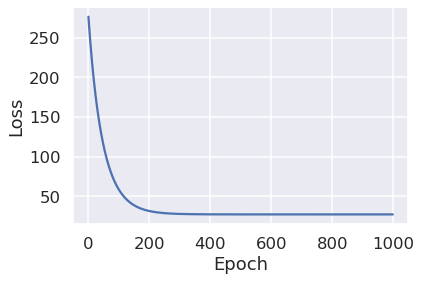

Our estimated theta: [22.2942 -1.847   0.5188 -2.0753  1.3941 -1.3942]
OLS estimated theta: [22.2951 -1.8426  0.5068 -2.1261  1.3926 -1.3554]


In [15]:
# Fit the scaler (estimate means and variances) on the training data.
scaler = preprocessing.StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)

theta = gradient_descent(scaled_train_data[:,0:5], train_labels, .01, 1000)
print('Our estimated theta:', theta)
print('OLS estimated theta:', OLS(scaled_train_data[:,0:5], train_labels))

### Extensions

#### Iterative methods
Why are we bothering with an iterative method like gradient descent when OLS gives a closed form solution? Linear regression happens to have a nice closed form solution, but most other objectives do not. In logistic regression, we apply the **logistic function** (also called **sigmoid**) to the output of the affine transform, which maps values in $[-\infty, \infty]$ to $[0, 1]$ and typically compute the loss using classification labels 0 and 1. Logistic regression has no closed form solution, so we need to use some kind of gradient descent.

#### Stochastic gradient descent
The full gradient descent algorithm we implemented above computes the loss and the gradient using all the training data. An alternative is to make parameter updates by picking up one training example at a time (randomly sampled). This **stochastic** version makes noisier estimates, but many more parameter updates, so the net effect approximates gradient descent (via the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)), but can be much more efficient.

#### Mini-batch stochastic gradient descent

Yet another alternative for approximating gradient descent is to randomly select small batches of training examples and making parameter updates based on these **mini-batches**. This is sort of happy medium between full gradient descent and the one-at-a-time stochastic version, and is most commonly used in practice.

#### Backpropagation

The backpropagation algorithm is an application of gradient descent to networks with multiple layers. We can specify a two-layer network, with parameters $\theta$, as the composition of two functions: $h_\theta(x) = f_\theta(g_\theta(x))$, where $g$ corresponds to layer 1 and $f$ corresponds to layer 2. As usual, we use our current parameters $\theta$ to make predictions, then compute gradients (with respect to the loss between predictions and labels). Computing these gradients sounds like it might be tricky. But because of the chain rule, we can actually compute the gradients one layer at a time, thus **backpropagating** the loss one layer at a time. Here's a nice [tutorial with cartoons](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-3-4a5bfd72294a).